In [1]:
# Auto reload module
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import yaml
import datetime
import argparse
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# set tf to cpu only
import tensorflow as tf
tf.config.set_visible_devices([], "GPU")
import jax
jax.config.update("jax_platform_name", "cpu")

import sys
sys.path.append("/robin-west/VBD")

from vbd.data.dataset import WaymaxDataset
from vbd.model.VBD import VBD
from torch.utils.data import DataLoader

import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.loggers import WandbLogger, CSVLogger
from lightning.pytorch.strategies import DDPStrategy

from matplotlib import pyplot as plt

In [3]:
def load_config(file_path):
    with open(file_path, "r") as file:
        data = yaml.safe_load(file)
    return data

In [4]:
# config_path = "/robin-west/VBD/config/_table_2/vbd_ego_agent_future_len_40_input_action_normalize_true_prior_means_steer_and_speed_scale_15_no_cond_attn_ego_validate.yaml"
config_path = "/robin-west/VBD/config/_table_2/vbd_ego_agent_future_len_40_input_action_normalize_true_prior_means_steer_and_speed_scale_0_no_cond_attn_ego_classifier_validate_100.yaml"
# config_path = "/robin-west/VBD/config/_table_2/vbd_ego_agent_future_len_40_input_action_normalize_true_prior_means_steer_and_speed_scale_0_no_cond_attn_ego_classifier_validate_10.yaml"
# config_path = "/robin-west/VBD/config/_table_2/vbd_ego_agent_future_len_40_input_action_normalize_true_prior_means_steer_and_speed_scale_0_no_cond_attn_ego_classifier_validate_1.yaml"
# config_path = "/robin-west/VBD/config/_table_2/vbd_ego_agent_future_len_40_input_action_normalize_true_prior_means_steer_and_speed_scale_0_cond_attn_ego_validate.yaml"
# config_path = "/robin-west/VBD/config/mean/VBD_train_on_full_dataset_validate.yaml"
# config_path = "/robin-west/VBD/config/_final_validate/vbd_ego_agent_future_len_40_input_action_normalize_true_prior_means_steer_and_speed_scale_0_no_cond_attn_ego_validate.yaml"
cfg = load_config(config_path)
cfg['num_workers'] = 1
cfg['batch_size'] = 1
dataset_dir = '/root/single_agent_subset/validation/processed'

In [5]:
pl.seed_everything(cfg["seed"])
torch.set_float32_matmul_precision("high")    
    
# create dataset
from vbd.data.dataset import WaymaxTestDataset

val_dataset = WaymaxTestDataset(
    data_dir=dataset_dir,
    future_len = cfg["future_len"],
    anchor_path=cfg["anchor_path"],
    predict_ego_only=cfg["predict_ego_only"],
    action_labels_path=cfg["validation_action_labels_path"],
    max_object= cfg["agents_len"],
)

Seed set to 42


In [6]:
from copy import deepcopy
import random

from vbd.waymax_visualization.plotting import plot_ego, plot_state, plot_ego_video
import mediapy

In [7]:
import jax
import matplotlib.pyplot as plt
import numpy as np
def plot_batch_x_t_with_all_labels(scenario,agents_interested,x_t_history, timestep, batch, run_ids=None):
    assert timestep < len(x_t_history)
    steer_label_name = {
        0: 'go straight',
        1: 'left turn',
        2: 'right turn',
        3: 'U-turn',
    }
    speed_label_name = {
        1: 'accelerate',
        2: 'decelerate',
        3: 'keep speed'
    }
    x_ts = x_t_history[timestep]
    if run_ids is None:
        run_ids = np.arange(x_ts.shape[0])
    for i in run_ids:
        steer_label = batch[i]['sdc_steer_label']
        speed_label = batch[i]['sdc_speed_label'] # + 1 # reminder: remove this +1 for model after 0224
        print('id_{}_steer_{}_speed_{}'.format(i, steer_label_name[steer_label], speed_label_name[speed_label]))
        traj = x_ts[i]
        img = plot_ego(
            scenario, 
            ego_traj = traj[agents_interested[i]>0].detach().cpu().numpy(), 
            log_traj=True
            )
        # torch.norm(denoiser_outputs['denoised_trajs'][agents_interested>0][:, -1, 2:4])
        mediapy.show_image(img, width=400)

def plot_batch_all_x_t(scenario,agents_interested, x_ts, timestep, batch, run_ids=None):
    steer_label_name = {
        0: 'go straight',
        1: 'left turn',
        2: 'right turn',
        3: 'U-turn',
    }
    speed_label_name = {
        1: 'accelerate',
        2: 'decelerate',
        3: 'keep speed'
    }
    # print(agents_interested)
    
    img = plot_ego(
        scenario, 
        traj_pred=x_ts, 
        log_traj=True
        )
    # torch.norm(denoiser_outputs['denoised_trajs'][agents_interested>0][:, -1, 2:4])
    mediapy.show_image(img, width=400)


def plot_batch_all_x_with_style(scenario,agents_interested, x_ts, style_dict, control_list, plot_freq, dx, filename):
    steer_label_name = {
        0: 'go straight',
        1: 'left turn',
        2: 'right turn',
        3: 'U-turn',
    }
    speed_label_name = {
        1: 'accelerate',
        2: 'decelerate',
        3: 'keep speed'
    }
    # print(agents_interested)
    
    img = plot_ego(
        scenario, 
        traj_pred=x_ts, 
        log_traj=True,
        style_dict=style_dict,
        control_list=control_list,
        plot_freq = plot_freq,
        dx = dx,
        filename=filename,
        )
    # torch.norm(denoiser_outputs['denoised_trajs'][agents_interested>0][:, -1, 2:4])
    mediapy.show_image(img, width=800)


def video(scenario,agents_interested, x_ts, style_dict, control_list, plot_freq, dx, filename=None):
    steer_label_name = {
        0: 'go straight',
        1: 'left turn',
        2: 'right turn',
        3: 'U-turn',
    }
    speed_label_name = {
        1: 'accelerate',
        2: 'decelerate',
        3: 'keep speed'
    }
    # print(agents_interested)
    
    imgs = plot_ego_video(
        scenario, 
        traj_pred=x_ts, 
        log_traj=False,
        style_dict=style_dict,
        control_list=control_list,
        plot_freq = plot_freq,
        dx = dx,
        filename=filename,
        )
    # # torch.norm(denoiser_outputs['denoised_trajs'][agents_interested>0][:, -1, 2:4])
    # mediapy.show_image(img, width=800)
    return imgs

In [8]:
def sample_with_random_id(val_dataset, i, speed_label, steer_label, size=16):
    if type(i) is int:
        scenario_id, scenario, data_dict = val_dataset.get_scenario_by_index(i)
    elif type(i) is str:
        scenario_id, scenario, data_dict = val_dataset.get_scenario_by_id(i)
    scenario.object_metadata.is_controlled = scenario.object_metadata.is_sdc
    # print(data_dict['sdc_speed_label'], data_dict['sdc_steer_label'])

    # print(scenario_id)

    data_dict_ = deepcopy(data_dict)
    print(data_dict_['sdc_speed_label'],data_dict_['sdc_steer_label'])
    data_dict_['sdc_steer_label'] = steer_label
    data_dict_['sdc_speed_label'] = speed_label

    batch = [data_dict_] * size
    batch_collated = val_dataset.__collate_fn__(batch)

    model = VBD(cfg=cfg)
    ckpt_path = cfg.get("init_from", None)
    print("Load Weights from ", ckpt_path)
    model.load_state_dict(torch.load(ckpt_path, map_location=torch.device("cuda"))["state_dict"])
    device = torch.device("cuda:0")
    model.to(device)
    log_dict, denoiser_outputs, agents_interested, x_t_history = model.sample_denoiser(batch_collated, calc_loss=True)   # log_dict compute the mean over all labels
    # print(log_dict)
    # print("**********",denoiser_outputs['denoised_trajs'][agents_interested>0][:,:,2])
    return scenario, agents_interested, x_t_history, batch


def get_all(control_list, val_dataset, sid, size):
    results = []
    for control in control_list:
        speed = control[0]
        steer = control[1]
        scenario, agents_interested, x_t_history, batch = sample_with_random_id(val_dataset, sid, speed, steer, size=size)
        x_ts = x_t_history[-1]
        results.append(x_ts[agents_interested>0].unsqueeze(1).detach().cpu().numpy())
    return np.asarray(results), scenario, agents_interested, batch




In [9]:
# '4477AA', 'EE6677', '228833', 'CCBB44', '66CCEE', 'AA3377', 'BBBBBB'
# style_dict = {
#     (-1,-1): {
#         'color': 'k',
#         'end_marker': 'x',
#     },
#     (0,0): {
#         'color': '#B00020',
#         'end_marker': 'x',
#     },
#     (1,0): {
#         'color': '#3700B3',
#         'end_marker': 'x',
#     },
#     (1,1): {
#         'color': '#3700B3',
#         'end_marker': '.',
#     },
#     (1,2): {
#         'color': '#3700B3',
#         'end_marker': '*',
#     },
#     (2,0): {
#         'color': '#AA3377',
#         'end_marker': 'x',
#     },
#     (2,1): {
#         'color': '#AA3377',
#         'end_marker': '.',
#     },
#     (2,2): {
#         'color': '#AA3377',
#         'end_marker': '*',
#     },
#     (3,0): {
#         'color': '#FFD500',
#         'end_marker': 'x',
#     },
#     (3,1): {
#         'color': '#FFD500',
#         'end_marker': '.',
#     },
#     (3,2): {
#         'color': '#FFD500',
#         'end_marker': '*',
#     },
# }
style_dict = {
    (-1,-1): {
        'color': 'k',
        'end_marker': 'x',
    },
    (0,0): {
        'color': '#3700B3',
        'end_marker': 'x',
    },
    (1,0): {
        'color': '#3700B3',
        'end_marker': 'x',
    },
    (1,1): {
        'color': '#3700B3',
        'end_marker': 'x',
    },
    (1,2): {
        'color': '#3700B3',
        'end_marker': 'x',
    },
    (2,0): {
        'color': '#3700B3',
        'end_marker': 'x',
    },
    (2,1): {
        'color': '#3700B3',
        'end_marker': 'x',
    },
    (2,2): {
        'color': '#3700B3',
        'end_marker': 'x',
    },
    (3,0): {
        'color': '#3700B3',
        'end_marker': 'x',
    },
    (3,1): {
        'color': '#3700B3',
        'end_marker': 'x',
    },
    (3,2): {
        'color': '#3700B3',
        'end_marker': 'x',
    },
    (1,3): {
        'color': '#3700B3',
        'end_marker': 'x',
    },
    (2,3): {
        'color': '#3700B3',
        'end_marker': 'x',
    },
    (3,3): {
        'color': '#3700B3',
        'end_marker': 'x',
    },
}

legend_key = {
    (-1,-1): 'Reference',
    (0,0): 'Unimodal',
    (1,0): 'Accelerate, Straight',
    (1,1): 'Accelerate, Left',
    (1,2): 'Accelerate, Right',
    (2,0): 'Decelerate, Straight',
    (2,1): 'Decelerate, Left',
    (2,2): 'Decelerate, Right',
    (3,0): 'Keep Speed, Straight',
    (3,1): 'Keep Speed, Left',
    (3,2): 'Keep Speed, Right',
}

In [10]:
# import matplotlib.pyplot as plt
# import matplotlib.lines as mlines

# fig, ax = plt.subplots()

# # Create a list of Line2D objects representing each style.
# legend_handles = []
# for key, style in style_dict.items():
#     handle = mlines.Line2D(
#         [], [], 
#         color=style['color'], 
#         marker=style['end_marker'],
#         linestyle='None',
#         markersize=10,
#         label=legend_key[key]
#     )
#     legend_handles.append(handle)

# # Number of columns matches the number of items so they can all fit on one line
# ncols = len(legend_handles)

# # Create the legend at the bottom, horizontally
# ax.legend(
#     handles=legend_handles, 
#     loc='lower center', 
#     bbox_to_anchor=(0.5, -0.2),  # Adjust the vertical position if needed
#     ncol=ncols,
#     frameon=True,  # Whether or not to show the legend border
#     prop={'family': 'Times New Roman', 'weight': 'bold'},
# )

# plt.show()

In [11]:
final_results = []

In [12]:
# i = "680be93f8a7c136f"#random.randint(0, len(val_dataset))   
# i = "1ce38b73d8f33a1c"
# i = 2223
# i = "680be93f8a7c136f"  # fig2 #3
# i = "1ce38b73d8f33a1c"
# i = "6be68aa2b9e66ca8"  # scenario5
# i = "30666897b753467b" 
# i = "15c52ccc83174652"  # fig 2 #1   [(1,0), (1,1), (3,0), (3,1)]

# i = "c1ada0034d4c9cb7"
# i = "fdefcebcd4686bd0"
# i = "5e897da6ea73b507"   #[(2,1), (2,0), (1,0), (3,1)] # viz_2_2
# i="247f416becfdbe93"
# i = "c7e6db85df853e12"
# i = "7872a8a27acb036c"
i = "26a8f8a819dbb1b5"

standard_control_list = [(1,0)]

control_list_straight = [(1,0), (3,0), (2,0)]
control_list_left = [(1,1), (3,1), (2,1)]
control_list_right = [ (1,2), (3,2), (2,2)]
size = 1

In [19]:
results, scenario, agents_interested, batch = get_all(standard_control_list, val_dataset, i, size=size)

3 0
Load Weights from  /robin-west/VBD/train_log_0225/vbd_ego_only_type_sample_schedule_linear_future_len_40_input_type_action_normalize_action_True_label_True_type_steer_and_speed_scale_0.0_cond_embed_None_diffuse_ego_True/epoch=63.ckpt


In [20]:
print(results.shape)

(1, 1, 1, 40, 5)


In [21]:
from dataclasses import replace

old_traj = scenario.log_trajectory
# scenario.sim_trajectory.x[10:50] = results[...,:,0]
# scenario.sim_trajectory.y[10:50] = results[...,:,1]
# scenario.sim_trajectory.yaw[10:50] = results[...,:,2]
# scenario.sim_trajectory.vel_x[10:50] = results[...,:,3]
# scenario.sim_trajectory.vel_y[10:50] = results[...,:,4]
is_ego = scenario.object_metadata.is_sdc
new_traj = replace(
    old_traj,
    x    = old_traj.x.at[is_ego,10:50].set(results[0, 0, 0, :, 0]),
    # x    = old_traj.x.at[is_ego,10:50].set(0.),
    y    = old_traj.y.at[is_ego,10:50].set(results[0, 0, 0, :, 1]),
    yaw  = old_traj.yaw.at[is_ego,10:50].set(results[0, 0, 0, :, 2]),
    vel_x= old_traj.vel_x.at[is_ego,10:50].set(results[0, 0, 0, :, 3]),
    vel_y= old_traj.vel_y.at[is_ego,10:50].set(results[0, 0, 0, :, 4]),
)
scenario.sim_trajectory = new_traj


# scenario.sim_trajectory = old_traj
# results[0,0,0,:,0] = old_traj.x[is_ego,10:50]
# results[0,0,0,:,1] = old_traj.y[is_ego,10:50]
# results[0,0,0,:,2] = old_traj.yaw[is_ego,10:50]
# results[0,0,0,:,3] = old_traj.vel_x[is_ego,10:50]
# results[0,0,0,:,4] = old_traj.vel_y[is_ego,10:50]

imgs = video(
        scenario = scenario,
        agents_interested = agents_interested,
        x_ts = results, 
        style_dict = style_dict, 
        control_list = standard_control_list,
        plot_freq = 1,
        dx=35,
        # filename='/robin-west/VBD/plots/pic1/viz_tease_right.pdf',
        )

In [22]:
print(batch[0]['sdc_speed_label'],batch[0]['sdc_steer_label'])

1 0


""

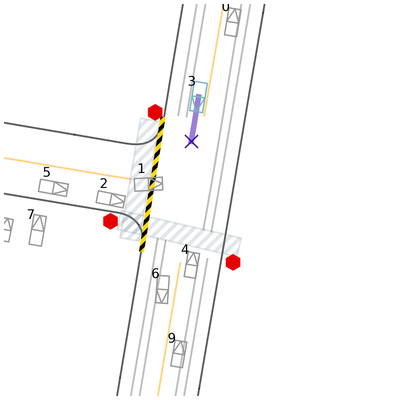

In [23]:
mediapy.show_image(imgs[0], width=400)

In [24]:
mediapy.show_video(imgs, fps=10)

In [33]:
# final_results.append(results)

In [34]:
results.shape

(1, 1, 1, 40, 5)

In [24]:
np.linalg.norm(results[-1,:,:,:,3:], axis=-1)

array([[[0.9618494 , 0.97862405, 1.2601395 , 1.3455132 , 1.3297712 ,
         1.3422365 , 1.2768962 , 1.0326117 , 1.3311372 , 1.3290584 ,
         1.3064096 , 1.4319206 , 1.204498  , 1.3633243 , 1.5262333 ,
         1.4770384 , 1.4532659 , 1.5771952 , 1.4958953 , 1.5324565 ,
         1.5984453 , 1.2690815 , 1.4166849 , 1.3323244 , 1.2656194 ,
         1.2929571 , 1.1459762 , 0.86999947, 0.60934556, 0.58195007,
         0.41975993, 0.5270837 , 0.2226916 , 0.31720883, 0.06002573,
         0.22789614, 0.20479089, 0.        , 0.        , 0.        ]]],
      dtype=float32)

In [8]:
results, scenario, agents_interested, batch = get_all(control_list_left, val_dataset, i, size=size)
plot_batch_all_x_with_style(
        scenario = scenario,
        agents_interested = agents_interested,
        x_ts = results, 
        style_dict = style_dict, 
        control_list = control_list_left,
        plot_freq = 1,
        dx=50,
        )

NameError: name 'get_all' is not defined

Load Weights from  /robin-west/VBD/train_log_0225/vbd_ego_only_type_sample_schedule_linear_future_len_40_input_type_action_normalize_action_True_label_True_type_steer_and_speed_scale_15.0_cond_embed_None_diffuse_ego_True/epoch=63.ckpt
tensor([6.5145], device='cuda:0') tensor([1.3141], device='cuda:0')
tensor([inf], device='cuda:0') tensor([5.3141], device='cuda:0')
tensor([True], device='cuda:0')
Load Weights from  /robin-west/VBD/train_log_0225/vbd_ego_only_type_sample_schedule_linear_future_len_40_input_type_action_normalize_action_True_label_True_type_steer_and_speed_scale_15.0_cond_embed_None_diffuse_ego_True/epoch=63.ckpt
tensor([2.8844], device='cuda:0') tensor([1.1004], device='cuda:0')
tensor([5.1004], device='cuda:0') tensor([-2.8996], device='cuda:0')
tensor([True], device='cuda:0')
Load Weights from  /robin-west/VBD/train_log_0225/vbd_ego_only_type_sample_schedule_linear_future_len_40_input_type_action_normalize_action_True_label_True_type_steer_and_speed_scale_15.0_cond_emb

""

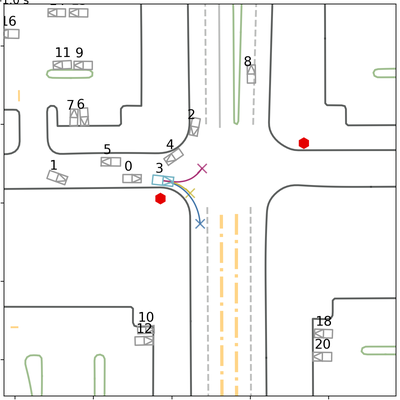

In [18]:
results, scenario, agents_interested, batch = get_all(control_list_right, val_dataset, i, size=size)
plot_batch_all_x_with_style(
        scenario = scenario,
        agents_interested = agents_interested,
        x_ts = results, 
        style_dict = style_dict, 
        control_list = control_list_right,
        plot_freq = 1,
        dx=50,
        )

In [24]:
torch.cuda.get_device_name(1)

'NVIDIA A10'

30666897b753467b


""

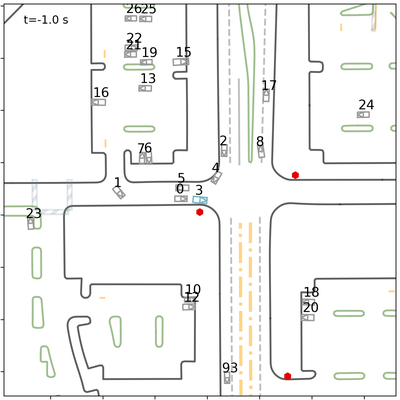

In [20]:
sid = "30666897b753467b"
scenario_id, scenario, data_dict = val_dataset.get_scenario_by_id(sid)
print(scenario_id)
mediapy.show_image(plot_state(scenario), width=400)

456
3fbd9d9c12bfe461


""

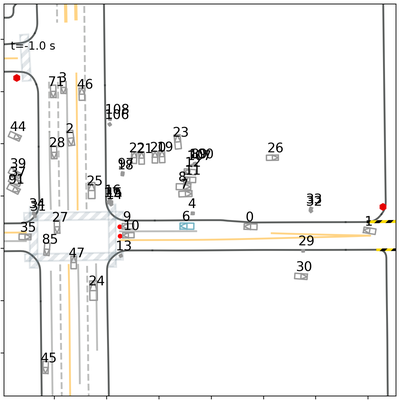

102
1e11ba3867b362df


""

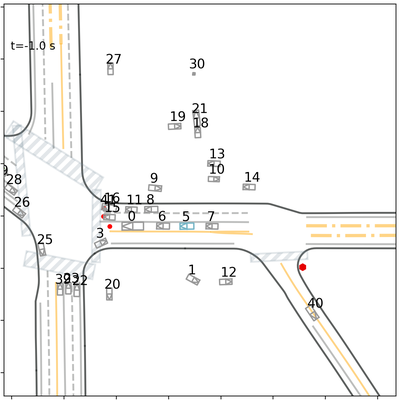

1126
40187ab8fdedace6


""

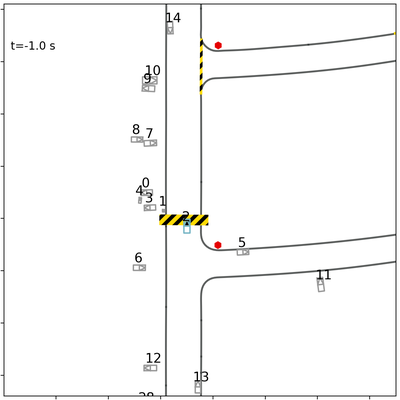

1003
d767462843fb9096


""

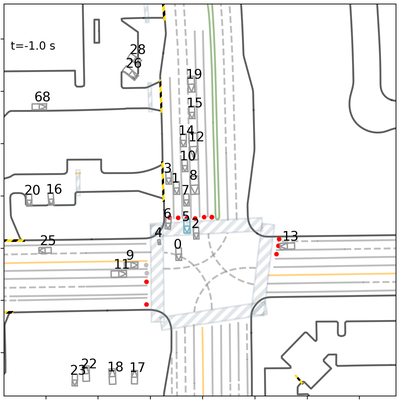

914
df18ba6e8fd79af6


""

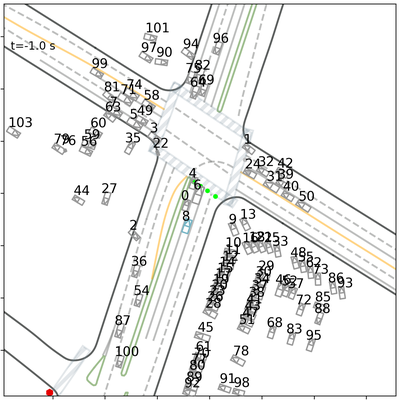

571
2a2dc5035fc76a23


""

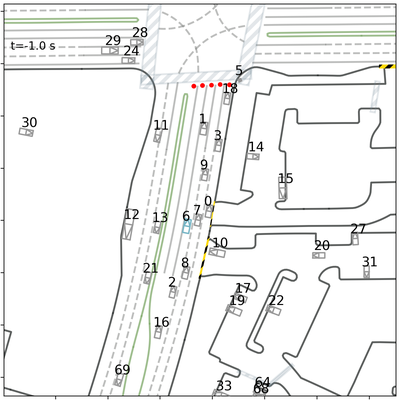

419
789ec24ff380e8fd


""

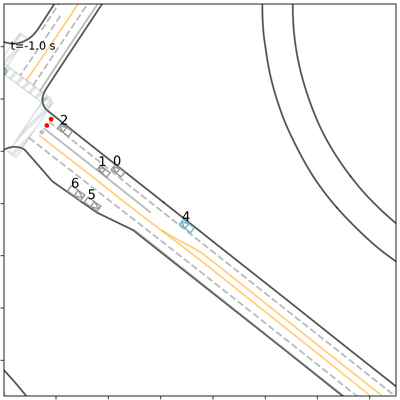

2233
7ad61e22e439966b


""

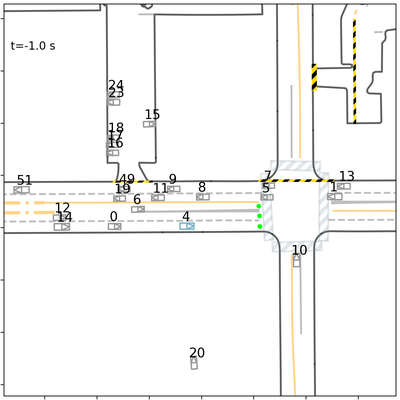

356
986f6b2aafc379cf


""

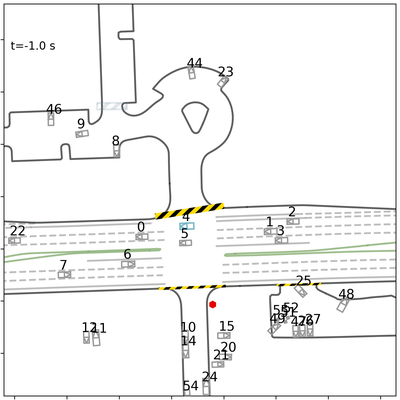

1728
757a6f39e6f44d6a


""

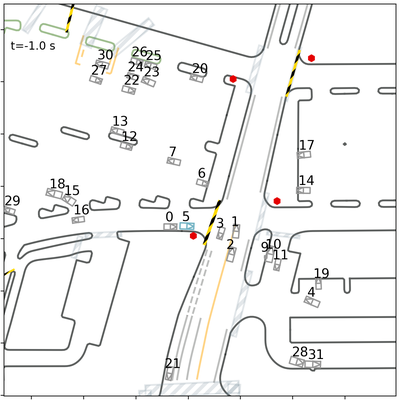

130
20057a6e5dc7ee93


""

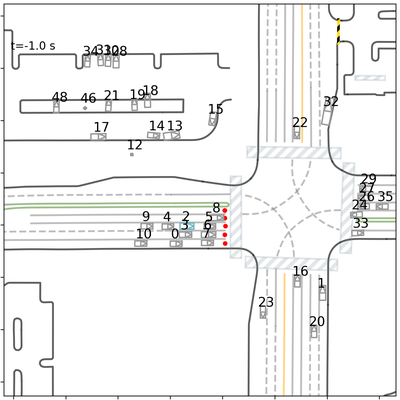

122
a02e679f2df464fb


""

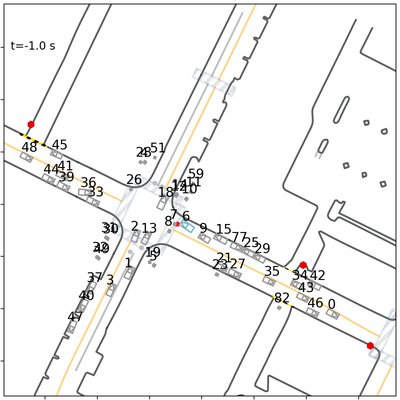

383
d8f768bb259f7a46


""

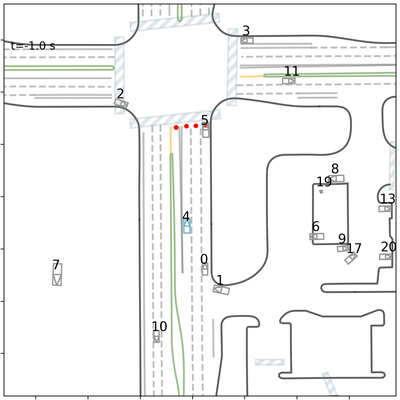

895
eb8d1a974cafda14


""

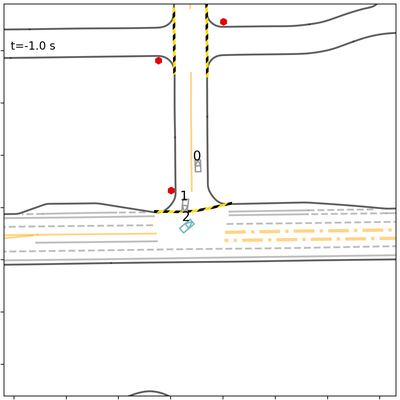

952
7872a8a27acb036c


""

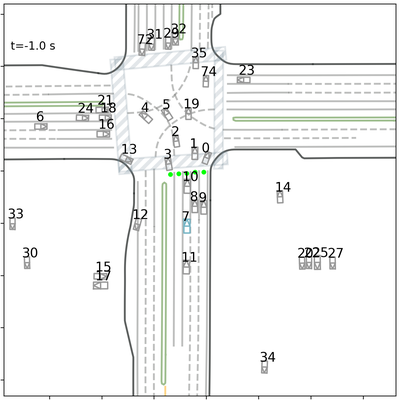

2069
aeec929c09f0dff4


""

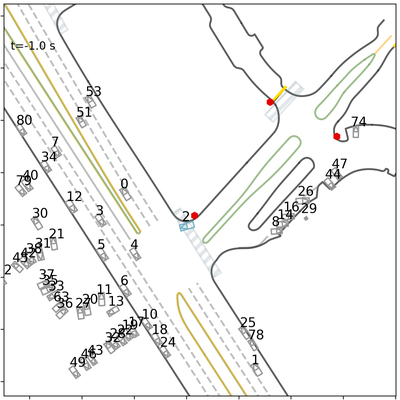

108
26a8f8a819dbb1b5


""

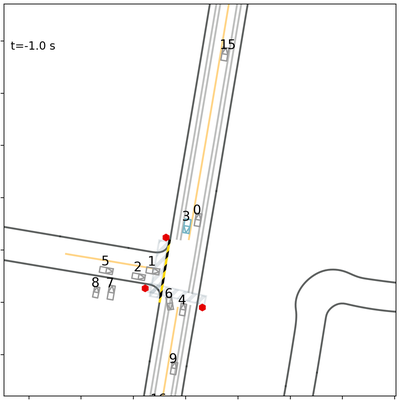

2298
999cb026d01794e3


""

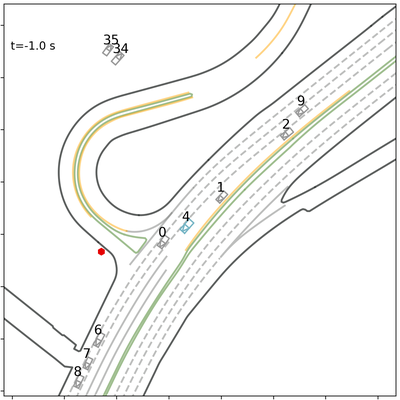

814
eaa42eec490ae1f7


""

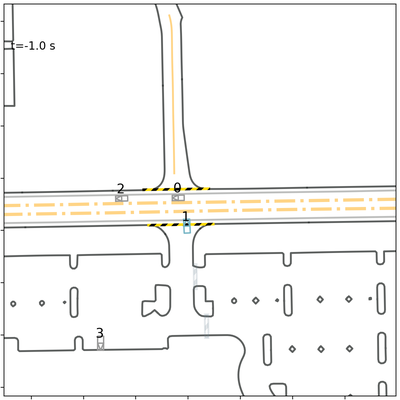

2232
f281e104094aea7d


""

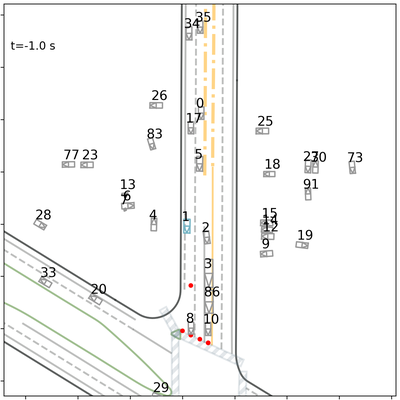

1718
eaa353edb2c55be8


""

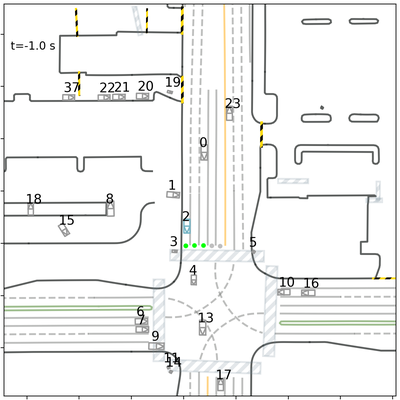

902
19c8272df7b1f38f


""

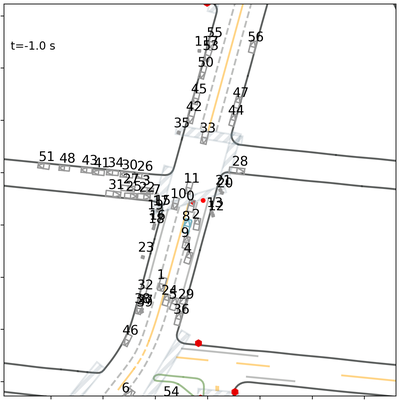

1839
f666d7dc2b0bcd94


""

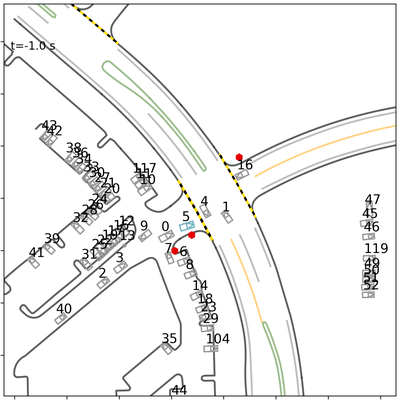

1139
5d1b27ed95d8424e


""

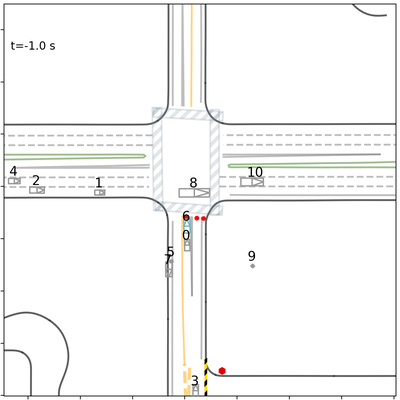

26
b5b288cc9ca44157


""

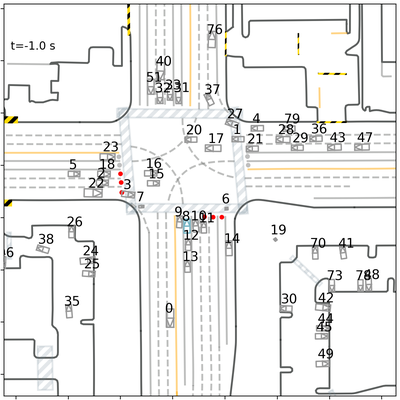

In [20]:
from vbd.waymax_visualization.plotting import plot_ego, plot_state
import mediapy
import random

ids = random.sample(range(len(val_dataset)), 25)
scenario_ids = []
gt_label = []
for i in ids:
    print(i)
    scenario_id, scenario, data_dict = val_dataset.get_scenario_by_index(i)
    print(scenario_id)
    mediapy.show_image(plot_state(scenario), width=400)
    # scenario_ids.append(scenario_id) 
    # gt_label.append((data_dict['sdc_speed_label'], data_dict['sdc_steer_label']))

In [18]:
for i in range(len(scenario_ids)):
    scenario_id = scenario_ids[i]
    print('gt', gt_label[i])
    steer = gt_label[i][1]
    
    print(f'{scenario_id} {[(speed_label, steer) for speed_label in [1,2,3]]}')

gt (1, 1)
9587642ec0735328 [(1, 1), (2, 1), (3, 1)]
gt (3, 1)
bece504900b36ece [(1, 1), (2, 1), (3, 1)]
gt (1, 1)
79797ac47ab45e7d [(1, 1), (2, 1), (3, 1)]
gt (1, 2)
63a3395d0e213df1 [(1, 2), (2, 2), (3, 2)]
gt (3, 0)
dfa03fa2ccbebb44 [(1, 0), (2, 0), (3, 0)]
gt (3, 2)
fcb631377a0591f3 [(1, 2), (2, 2), (3, 2)]
gt (2, 0)
8bd164a5be01879c [(1, 0), (2, 0), (3, 0)]
gt (2, 1)
561a37f42049ee1e [(1, 1), (2, 1), (3, 1)]
gt (1, 2)
8dfea11f204f0364 [(1, 2), (2, 2), (3, 2)]
gt (1, 0)
2345a7a7459ffac5 [(1, 0), (2, 0), (3, 0)]
gt (1, 2)
30666897b753467b [(1, 2), (2, 2), (3, 2)]
gt (3, 2)
faa2f74aa6dd484e [(1, 2), (2, 2), (3, 2)]
gt (1, 0)
58cd3a30961c7b71 [(1, 0), (2, 0), (3, 0)]
gt (3, 0)
4c551995252bb2b7 [(1, 0), (2, 0), (3, 0)]
gt (1, 2)
959ddf73da7b7dfc [(1, 2), (2, 2), (3, 2)]
gt (3, 0)
b13e998042b6b3a1 [(1, 0), (2, 0), (3, 0)]
gt (1, 0)
a2eac893d90265e [(1, 0), (2, 0), (3, 0)]
gt (1, 2)
8838e947987365e1 [(1, 2), (2, 2), (3, 2)]
gt (3, 0)
3841a45c6449482a [(1, 0), (2, 0), (3, 0)]
gt (1, 2)
b35

In [33]:
selected_scenarios = {
    '7ad61e22e439966b': [(1,0), (2,0), (3,0), (2,1), (3,1)],
    '43537f04b1a92814': [(1,0), (2,0), (3,0), (1,1), (2,1), (3,1)],
    '6ad1e083e15e1f55': [(1,0), (2,0), (3,0), (1,1), (2,1), (3,1)],
    'b05224484e0636c1': [(1,0), (2,0), (3,0), (1,1), (2,1), (3,1), (1,2), (2,2), (3,2)],
    '19fdd02d3aa9f995':  [(1,0), (2,0), (3,0), (1,1), (2,1), (3,1)],
    '85f91b6c429c03f0': [(1,0), (2,0), (3,0), (1,1), (2,1), (3,1)],
    '680be93f8a7c136f': [(1,0), (2,0), (3,0), (1,2), (2,2), (3,2)],
    'd3312e0972099317': [(1,0), (2,0), (3,0), (1,2), (2,2), (3,2)],
    '1ce38b73d8f33a1c': [(1,0), (2,0), (3,0), (1,2), (2,2), (3,2)],
    '168c8bf713f0461a': [(1,0), (2,0), (3,0), (1,2), (2,2), (3,2)],
    '9587642ec0735328': [(1, 1), (2, 1), (3, 1)],
    'bece504900b36ece': [(1, 1), (2, 1), (3, 1)],
    '79797ac47ab45e7d': [(1, 1), (2, 1), (3, 1)],
    '63a3395d0e213df1': [(1, 2), (2, 2), (3, 2)],
    'dfa03fa2ccbebb44': [(1, 0), (2, 0), (3, 0)],
    'fcb631377a0591f3': [(1, 2), (2, 2), (3, 2)],
    '8bd164a5be01879c': [(1, 0), (2, 0), (3, 0)],
    '561a37f42049ee1e': [(1, 1), (2, 1), (3, 1)],
    '8dfea11f204f0364': [(1, 2), (2, 2), (3, 2)],
    '2345a7a7459ffac5': [(1, 0), (2, 0), (3, 0)],
    '30666897b753467b': [(1, 2), (2, 2), (3, 2)],
    'faa2f74aa6dd484e': [(1, 2), (2, 2), (3, 2)],
    '58cd3a30961c7b71': [(1, 0), (2, 0), (3, 0)],
    '4c551995252bb2b7': [(1, 0), (2, 0), (3, 0)],
    '959ddf73da7b7dfc': [(1, 2), (2, 2), (3, 2)],
    'b13e998042b6b3a1': [(1, 0), (2, 0), (3, 0)],
    'a2eac893d90265e': [(1, 0), (2, 0), (3, 0)],
    '8838e947987365e1': [(1, 2), (2, 2), (3, 2)],
    '3841a45c6449482a': [(1, 0), (2, 0), (3, 0)],
    'b35349e56679d928': [(1, 2), (2, 2), (3, 2)],
    '997e89f474252f9a': [(1, 2), (2, 2), (3, 2)],
    '75a69511d199fdfc': [(1, 0), (2, 0), (3, 0)],
    '5ab487d32a139b92': [(1, 1), (2, 1), (3, 1)],
    'f4a835f680d253d2': [(1, 1), (2, 1), (3, 1)],
    '8686e2bd7bf7b77b': [(1, 0), (2, 0), (3, 0)],
}

In [34]:
scene_action_combo = [
    (scid, action) for scid in  selected_scenarios.keys() for action in selected_scenarios[scid]
]

In [35]:
scene_action_combo

[('7ad61e22e439966b', (1, 0)),
 ('7ad61e22e439966b', (2, 0)),
 ('7ad61e22e439966b', (3, 0)),
 ('7ad61e22e439966b', (2, 1)),
 ('7ad61e22e439966b', (3, 1)),
 ('43537f04b1a92814', (1, 0)),
 ('43537f04b1a92814', (2, 0)),
 ('43537f04b1a92814', (3, 0)),
 ('43537f04b1a92814', (1, 1)),
 ('43537f04b1a92814', (2, 1)),
 ('43537f04b1a92814', (3, 1)),
 ('6ad1e083e15e1f55', (1, 0)),
 ('6ad1e083e15e1f55', (2, 0)),
 ('6ad1e083e15e1f55', (3, 0)),
 ('6ad1e083e15e1f55', (1, 1)),
 ('6ad1e083e15e1f55', (2, 1)),
 ('6ad1e083e15e1f55', (3, 1)),
 ('b05224484e0636c1', (1, 0)),
 ('b05224484e0636c1', (2, 0)),
 ('b05224484e0636c1', (3, 0)),
 ('b05224484e0636c1', (1, 1)),
 ('b05224484e0636c1', (2, 1)),
 ('b05224484e0636c1', (3, 1)),
 ('b05224484e0636c1', (1, 2)),
 ('b05224484e0636c1', (2, 2)),
 ('b05224484e0636c1', (3, 2)),
 ('19fdd02d3aa9f995', (1, 0)),
 ('19fdd02d3aa9f995', (2, 0)),
 ('19fdd02d3aa9f995', (3, 0)),
 ('19fdd02d3aa9f995', (1, 1)),
 ('19fdd02d3aa9f995', (2, 1)),
 ('19fdd02d3aa9f995', (3, 1)),
 ('85f91

In [36]:
import pickle
with open('/robin-west/VBD/config/_table_2/scenario_action_combo.pkl', 'wb') as scene_action_combo_f:
    pickle.dump(scene_action_combo, scene_action_combo_f)